✅ Loading and Preprocessing Data...
Memory Usage: 68.9% | Available: 2503.83 MB
✅ Running Local Outlier Factor...
Memory Usage: 68.7% | Available: 2513.48 MB
✅ Running DBSCAN...
Memory Usage: 68.9% | Available: 2500.20 MB
✅ Evaluating Models...

--- Local Outlier Factor (LOF) ---
Precision: 1.0000
Recall: 0.0114
F1-score: 0.0225
AUC-ROC: 0.5057

--- DBSCAN ---
Precision: 0.4032
Recall: 0.0158
F1-score: 0.0304
AUC-ROC: 0.4635
✅ Visualizing Results...


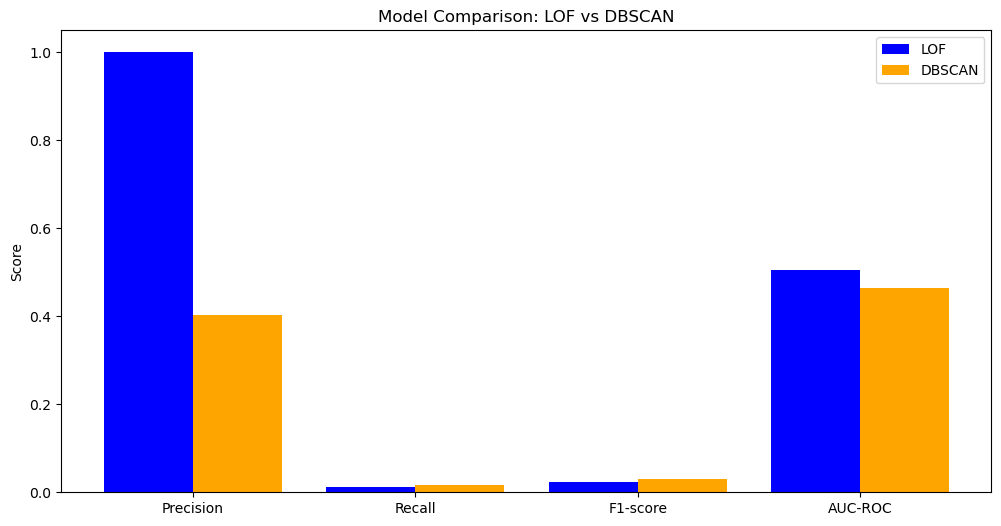

✅ Saving Results to CSV...
Results saved to: network_intrusion_detection_lof_dbscan_results.csv


In [6]:
# -------------------------------------
#  Import Libraries
# -------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import psutil

# -------------------------------------
# Load and Preprocess Dataset
# -------------------------------------
print(" Loading and Preprocessing Data...")

# Path to KDD-99 dataset
file_path = r"D:\Wise Work\Week 4\archive\kddcup.data_10_percent_corrected"

# Load a smaller sample for testing
data = pd.read_csv(file_path, header=None).sample(n=10000, random_state=42)

# Define column names (41 features + 1 label)
columns = [f'feature_{i}' for i in range(41)] + ['label']
data.columns = columns

# Encode labels (Normal = 0, Attack = 1)
data['label'] = data['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Split features and labels
X = data.drop(columns=['label'])
y = data['label']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Memory usage log
def log_memory_usage():
    mem = psutil.virtual_memory()
    print(f"Memory Usage: {mem.percent}% | Available: {mem.available / 1024 ** 2:.2f} MB")

log_memory_usage()

# -------------------------------------
# Local Outlier Factor (LOF)
# -------------------------------------
print(" Running Local Outlier Factor...")

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred_lof = lof.fit_predict(X_test)

# Map LOF predictions to binary labels (1 = anomaly, 0 = normal)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

log_memory_usage()

# -------------------------------------
#  DBSCAN (Density-Based Clustering)
# -------------------------------------
print("Running DBSCAN...")

# Adjust parameters for better performance
dbscan = DBSCAN(eps=0.9, min_samples=20)  # Optimized values
dbscan.fit(X_test)

# Map DBSCAN labels to anomaly/normal labels
y_pred_dbscan = np.where(dbscan.labels_ == -1, 1, 0)

log_memory_usage()

# -------------------------------------
# Evaluation and Comparison
# -------------------------------------
print(" Evaluating Models...")

def evaluate_model(y_true, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc_roc = roc_auc_score(y_true, y_pred)  # Use AUC-ROC

    print(f"\n--- {model_name} ---")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return precision, recall, f1, auc_roc

# Evaluate LOF
lof_metrics = evaluate_model(y_test, y_pred_lof, "Local Outlier Factor (LOF)")

# Evaluate DBSCAN
dbscan_metrics = evaluate_model(y_test, y_pred_dbscan, "DBSCAN")

# -------------------------------------
#  Visualization: Model Comparison
# -------------------------------------
print(" Visualizing Results...")

# Plot metrics
metrics = ['Precision', 'Recall', 'F1-score', 'AUC-ROC']
lof_scores = lof_metrics
dbscan_scores = dbscan_metrics

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics))

# Plot LOF and DBSCAN metrics
ax.bar(x - 0.2, lof_scores, width=0.4, label='LOF', color='blue')
ax.bar(x + 0.2, dbscan_scores, width=0.4, label='DBSCAN', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Model Comparison: LOF vs DBSCAN')
ax.legend()

plt.show()

# -------------------------------------
#  Save Results to CSV
# -------------------------------------
print(" Saving Results to CSV...")

# Save predictions
results = pd.DataFrame({
    "True_Label": y_test,
    "LOF_Prediction": y_pred_lof,
    "DBSCAN_Prediction": y_pred_dbscan
})

# Save the results
output_file = "network_intrusion_detection_lof_dbscan_results.csv"
results.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")
